In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt

In [14]:
iris = load_iris()
dataset = pd.DataFrame(data= np.c_[iris['data'], iris['target']],columns= iris['feature_names'] + ['species'])
dataset.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


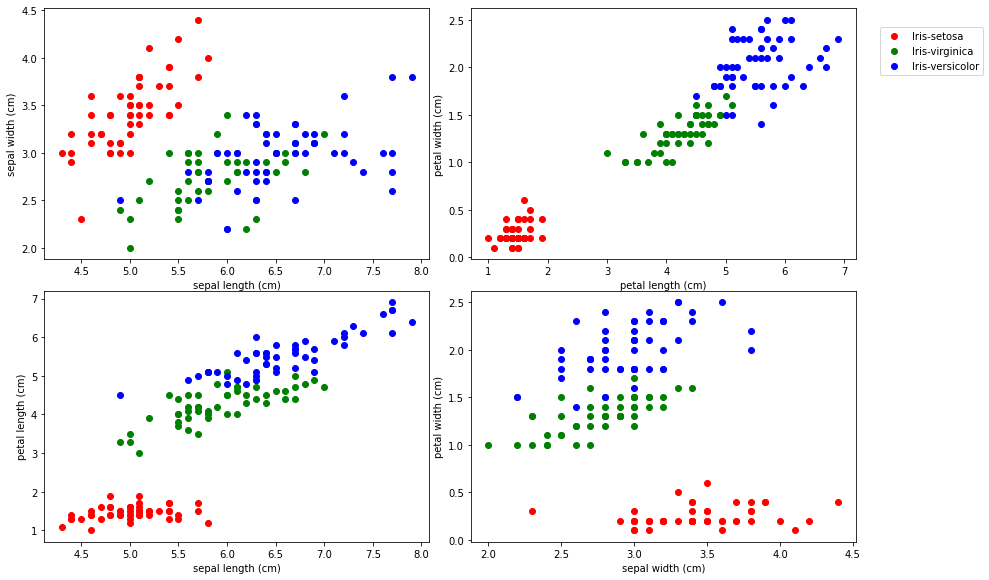

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ["r", "g", "b"]
labels = ["Iris-setosa","Iris-virginica","Iris-versicolor"]

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [16]:
X = dataset.drop("species",axis=1).values
y = dataset["species"].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

torch.Size([120, 4]) torch.Size([120]) torch.Size([30, 4]) torch.Size([30])


Fully Connected Layer 4 input features, 25 output features (arbitrary)

Fully Connected Layer 25 input features, 30 output features (arbitrary)

Output Layer 30 input features , 3 output features

We will use ReLU (rectified linear unit) as activation function. 

In [17]:
class Model(nn.Module):
    def __init__(self, input_features=4, hidden_layer1=25, hidden_layer2=30, output_features=3):
        super().__init__()
        self.fc1 = nn.Linear(input_features,hidden_layer1)                  
        self.fc2 = nn.Linear(hidden_layer1, hidden_layer2)                  
        self.out = nn.Linear(hidden_layer2, output_features)      
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [18]:
model = Model()
model

Model(
  (fc1): Linear(in_features=4, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=30, bias=True)
  (out): Linear(in_features=30, out_features=3, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [20]:
epochs = 200
losses = []

for i in range(epochs):
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    if i % 10 == 0:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0  loss: 1.17327249
epoch: 10  loss: 0.81953454
epoch: 20  loss: 0.43808597
epoch: 30  loss: 0.24071105
epoch: 40  loss: 0.11393118
epoch: 50  loss: 0.07845698
epoch: 60  loss: 0.06810436
epoch: 70  loss: 0.06415128
epoch: 80  loss: 0.06237421
epoch: 90  loss: 0.06172239
epoch: 100  loss: 0.06095406
epoch: 110  loss: 0.05964392
epoch: 120  loss: 0.05893719
epoch: 130  loss: 0.05942069
epoch: 140  loss: 0.05772536
epoch: 150  loss: 0.05718697
epoch: 160  loss: 0.05670518
epoch: 170  loss: 0.05704690
epoch: 180  loss: 0.05659183
epoch: 190  loss: 0.05573935


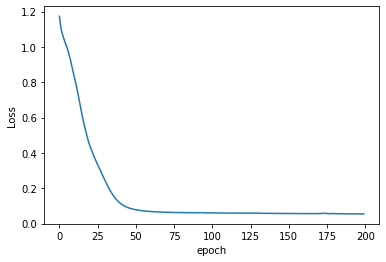

In [21]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [22]:
preds = []
with torch.no_grad():
    for val in X_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())
        
df = pd.DataFrame({'Y': y_test, 'YHat': preds})
df['Correct'] = [1 if corr == pred else 0 for corr, pred in zip(df['Y'], df['YHat'])]

print('Accuracy: ', df['Correct'].sum() / len(df))
print('Confusion Matrix:')
print(confusion_matrix(y_test,preds))

Accuracy:  1.0
Confusion Matrix:
[[10  0  0]
 [ 0 12  0]
 [ 0  0  8]]


#### Classify new random data point:

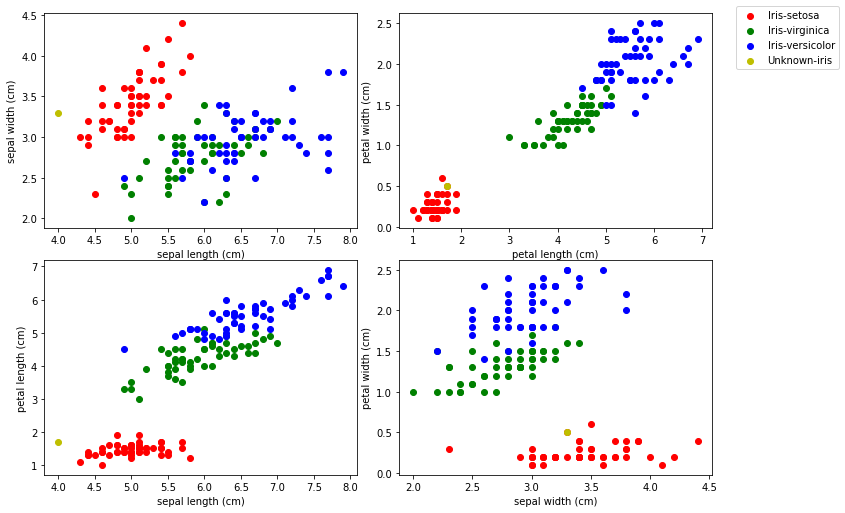

In [23]:
unknown_iris = torch.tensor([4.0,3.3,1.7,0.5])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['r', 'g', 'b']
labels = ['Iris-setosa','Iris-virginica','Iris-versicolor','Unknown-iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = dataset.columns[plots[i][0]]
        y = dataset.columns[plots[i][1]]
        ax.scatter(dataset[dataset["species"]==j][x], dataset[dataset["species"]==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    ax.scatter(unknown_iris[plots[i][0]],unknown_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [24]:
with torch.no_grad():
    print(model(unknown_iris))
    print()
    print('Unknown Iris of species:', labels[model(unknown_iris).argmax()])

tensor([ 11.6193,   5.1540, -17.2725])

Unknown Iris of species: Iris-setosa
